In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.formula.api as smf

In [2]:
#Define event date
event_date = '2024-08-13'

#Load data
prices = pd.read_csv('sbux_ceo_prices.csv')
prices = prices[prices['returns'].isnull()==0].copy()
prices.head()

,date,open,high,low,close,adjclose,volume,ticker,returns
1,2024-01-03,93.959999,94.239998,93.059998,93.230003,91.422096,7161700,SBUX,-0.004697
2,2024-01-04,93.099998,94.580002,93.000000,93.550003,91.735893,7118600,SBUX,0.003432
3,2024-01-05,93.330002,93.580002,92.480003,92.989998,91.186745,7189900,SBUX,-0.005986
4,2024-01-08,93.019997,94.570000,92.949997,94.190002,92.363480,7536900,SBUX,0.012905
5,2024-01-09,93.610001,93.730003,92.860001,93.089996,91.284805,6348500,SBUX,-0.011679


In [3]:
#Define total shares of SBUX
total_shares = 1132800000

#Filter data before the event
pre = prices[prices['date']<event_date].copy()

#Find last price before CEO announcement for SBUX
lastprice = pre.loc[(pre['date']==max(pre['date'])) & (pre['ticker']=='SBUX'),'close'].values[0]

#Calculate Last Market Value
lastmarketvalue = lastprice * total_shares
print(f"Last Market Value: $ {round(lastmarketvalue)}")

#Summarize statistics before the event
prices[prices['date']<event_date].groupby(['ticker'])['returns'].agg(['count','mean','std'])

Last Market Value: $ 87259582617


,count,mean,std
ticker,,,
MCD,153,-0.000568,0.011725
QSR,153,-0.000522,0.014667
SBUX,153,-0.001079,0.019548
VOO,153,0.000826,0.007927
YUM,153,0.000379,0.010292


### Event Study Model

In [4]:
#Pivot DataFrame
df_wide = prices.pivot(index='date', columns='ticker', values='returns')
df_wide.reset_index(inplace=True)
df_wide.columns.name = None

#Convert date to datetime
df_wide['date'] = pd.to_datetime(df_wide['date'])

df_wide.head()

,date,MCD,QSR,SBUX,VOO,YUM
0,2024-01-03,-0.008921,-0.005985,-0.004697,-0.007419,0.000543
1,2024-01-04,-0.009002,-0.000916,0.003432,-0.003157,-0.003176
2,2024-01-05,-0.009426,0.001310,-0.005986,0.001281,-0.002720
3,2024-01-08,0.010070,0.022635,0.012905,0.014303,0.002338
4,2024-01-09,-0.003529,-0.003199,-0.011679,-0.002430,-0.003265


In [5]:
#Define cuttoff date
cutoff_days = 120
event_date = pd.to_datetime(event_date)
cutoff = event_date - datetime.timedelta(days=cutoff_days)

#Filter data for the analysis window
df = df_wide[(df_wide['date'] >= cutoff) & (df_wide['date'] <= event_date)].copy()

#Create event indicator variable
df['event'] = np.where(df['date']==event_date,1,0)

#Define and fit regression model
formula = 'SBUX~MCD+QSR+VOO+YUM+event'
model = smf.ols(formula=formula, data=df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   SBUX   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     31.66
Date:                Fri, 30 Aug 2024   Prob (F-statistic):           1.81e-17
Time:                        14:29:58   Log-Likelihood:                 206.12
No. Observations:                  84   AIC:                            -400.2
Df Residuals:                      78   BIC:                            -385.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0006      0.002     -0.242      0.8

In [6]:
print("Estimated Gain: ${:,}".format(round(lastmarketvalue*model.params['event'])))

Estimated Gain: $19,955,241,349


In [8]:
def get_event_study_placebos(df_wide, pre_event_dates, cutoff_days, formula):
    pvalues = list()
    betas = list()
    
    #Loop through each placebo date
    for placebo_date in pre_event_dates:
        
        #Define cuttoff date and filter data
        cutoff = pd.to_datetime(placebo_date) - datetime.timedelta(days=cutoff_days)
        placebo_df = df_wide[(df_wide['date'] >= cutoff) & (df_wide['date'] <= placebo_date)].copy()
        placebo_df['event'] = np.where(placebo_df['date']==placebo_date,1,0)
        
        #Fit regression model
        placebo_model=smf.ols(formula=formula, data=placebo_df).fit()
        
        #Store results
        pvalues.append(placebo_model.pvalues['event'])
        betas.append(placebo_model.params['event'])

    #Create DataFrame for Placebo Estimates
    placebo_estimates = pd.DataFrame({'betas':betas, 'pvalues':pvalues})
    
    #Calculate RMSE
    rmse = np.sqrt((placebo_estimates['betas']**2).mean())

    return(placebo_estimates,rmse)

In [9]:
#Define placebo start date
placebo_start = event_date - datetime.timedelta(days=cutoff_days)

#Get unique pre-event dates for placebos
pre_event_dates = df_wide[(df_wide['date'] >= placebo_start) & (df_wide['date'] < event_date)]['date'].unique()

placebo_estimates, rmse = get_event_study_placebos(df_wide, pre_event_dates, cutoff_days, formula)

print(f"RMSE: {rmse:.3f}")

RMSE: 0.025


In [10]:
def plot_histogram(df, model, param, mytitle):
    quantile_2_5 = df['betas'].quantile(0.025)
    quantile_97_5 = df['betas'].quantile(0.975)
    model_est = model.params[param]

    plt.hist(df['betas'], bins=10, alpha=0.7)
    plt.axvline(quantile_2_5, color='black', linestyle='--', linewidth=1, label='2.5th pctl')
    plt.axvline(quantile_97_5, color='black', linestyle='--', linewidth=1, label='97.5th pctl')
    plt.axvline(model_est, color='red', linestyle='--', linewidth=1, label='Event Impact')
    plt.legend(loc='upper left')
    plt.title(mytitle)
    plt.show()

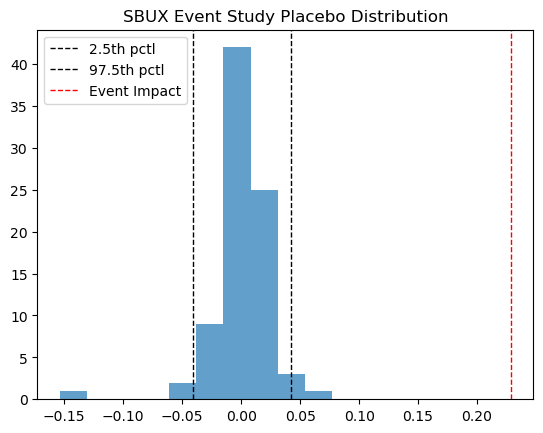

In [12]:
mytitle = "SBUX Event Study Placebo Distribution"
plot_histogram(placebo_estimates, model,"event", mytitle)

### Estimate Difference-in-Difference Model

In [15]:
def run_diff_in_diff(df, event_date, treated):
    
    #Define analysis period and filter data
    start_date = event_date - datetime.timedelta(days=180)
    df = df[(df['date'] >= start_date) & (df['date'] <= event_date) & (df['returns'].isnull()==0)].copy()
    
    #Create treatment and time variables
    df['treated'] = np.where(df['ticker']==treated, 1, 0)
    df['post'] = np.where(df['date']>=event_date, 1, 0)
    df['treated_post'] = df['treated'] * df['post']
    
    #Define and fit regression model
    formula = "returns ~ treated + post + treated_post"
    model = smf.ols(formula=formula, data=df).fit()
    
    return model

In [17]:
#Convert date to datetime and define treated group
event_date = pd.to_datetime(event_date)
prices['date'] = pd.to_datetime(prices['date'])
treated = 'SBUX'

#Run Difference-in-Difference Analysis
model = run_diff_in_diff(prices, event_date, treated)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     105.2
Date:                Fri, 30 Aug 2024   Prob (F-statistic):           5.40e-55
Time:                        15:16:55   Log-Likelihood:                 1774.3
No. Observations:                 620   AIC:                            -3541.
Df Residuals:                     616   BIC:                            -3523.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -9.701e-05      0.001     -0.155   

In [18]:
#Define placebo start date
placebo_start = event_date - datetime.timedelta(days=120)
prices['date'] = pd.to_datetime(prices['date'])

#Define placebo dates
pre_event_dates = prices[(prices['date'] >= placebo_start) & (prices['date'] < event_date)]['date'].unique()

pvalues = list()
betas = list()

#Perform Placebo Testing
for placebo_date in pre_event_dates:
    placebo_model=run_diff_in_diff(prices, pd.to_datetime(placebo_date), treated)
    pvalues.append(placebo_model.pvalues['treated_post'])
    betas.append(placebo_model.params['treated_post'])

#Store results in a DataFrame
df = pd.DataFrame({'betas':betas, 'pvalues':pvalues})

#Calculate RMSE
rmse = np.sqrt((df['betas']**2).mean())
print(f"RMSE: {rmse:.3f}")

RMSE: 0.022


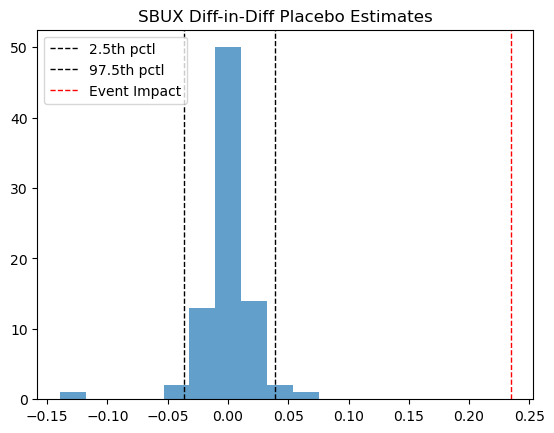

In [20]:
mytitle = "SBUX Diff-in-Diff Placebo Estimates"
plot_histogram(df, model, "treated_post", mytitle)

In [21]:
print("Estimated Gain: ${:,}".format(round(lastmarketvalue*model.params['treated_post'])))

Estimated Gain: $20,476,849,918
